#Data Load

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"stevanuso","key":"3be2f227bebbea34e6685c0a61a4118f"}'}

In [2]:
!mkdir ~/.kaggle #make new directory in root folder
!cp kaggle.json ~/.kaggle/ #copy and paste kaggle API key to new directory
!chmod 600 ~/.kaggle/kaggle.json #permission

In [3]:
!kaggle datasets download -d ishantjuyal/emotions-in-text

  0% 0.00/781k [00:00<?, ?B/s]
100% 781k/781k [00:00<00:00, 136MB/s]


In [4]:
import os 
import zipfile

In [104]:
Zippath = '../content/emotions-in-text.zip'
ZipFile = zipfile.ZipFile(Zippath, 'r')
ZipFile.extractall('../content/emotion-in-text') #extract to new directory
ZipFile.close() #close connection to object

#Data Preprocessing

In [122]:
import pandas as pd

In [123]:
filePath = '../content/emotion-in-text/Emotion_final.csv'
df = pd.read_csv(filePath)
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [124]:
df['Emotion'].value_counts()

happy       7029
sadness     6265
anger       2993
fear        2652
love        1641
surprise     879
Name: Emotion, dtype: int64

In [125]:
df.isnull().sum()

Text       0
Emotion    0
dtype: int64

In [126]:
#Not using stopwords because there an important words get deleted
# import nltk
# nltk.download('stopwords')
# from nltk.corpus import stopwords 
# from nltk.tokenize import word_tokenize
# stop_words = set(stopwords.words('english'))

# df['Text'] = df['Text'].apply(lambda x: ' '.join([w for w in x if not w.lower() in stop_words]))

In [127]:
#One Hot Encoding
category = pd.get_dummies(df.Emotion)
df1 = pd.concat([df, category], axis=1)
df1 = df1.drop(columns='Emotion')

In [128]:
X = df1['Text'].values
y = df1[['happy', 'sadness', 'anger', 'fear', 'love', 'surprise']].values

In [129]:
from sklearn.model_selection import train_test_split

In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [131]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot

In [132]:
tokenizer = Tokenizer(num_words = 5000, oov_token='<x>', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True)
tokenizer.fit_on_texts(X_train)
tokenizer.fit_on_texts(X_test)

Seq_train = tokenizer.texts_to_sequences(X_train)
Seq_test = tokenizer.texts_to_sequences(X_test)

Pad_train = pad_sequences(Seq_train)
Pad_test = pad_sequences(Seq_test)

#Model Construction

In [134]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, Dense, Dropout, BatchNormalization, Flatten, LSTM
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau

In [135]:
model = Sequential([
    Embedding(input_dim = 5000, output_dim = 24),
    BatchNormalization(),
    LSTM(128, return_sequences=True),
    BatchNormalization(),
    LSTM(128),
    Dropout(0.2),
    BatchNormalization(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(128, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(64, activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    Dense(6, activation='softmax')
])

In [136]:
class callbackTarget(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy') >= 0.91 and logs.get('accuracy') >= 0.91):
      print('\nVal_accuracy and accuracy has reached >= 91%!')
      self.model.stop_training = True

callbacks = callbackTarget()

LR_reduction = ReduceLROnPlateau(
    monitor = 'val_loss',
    patience = 3, 
    verbose = 1,
    factor = 0.2,
    min_lr = 0.000003
)

In [137]:
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

#Model Train and Val

In [138]:
history = model.fit(
    Pad_train, y_train,
    epochs = 500,
    batch_size = 128,
    validation_data = (Pad_test, y_test),
    verbose = 1,
    callbacks = [callbacks, LR_reduction]
)

Epoch 1/500
135/135 [==============================] - 8s 26ms/step - loss: 1.9968 - accuracy: 0.2315 - val_loss: 1.6371 - val_accuracy: 0.3029 - lr: 0.0010
Epoch 2/500
135/135 [==============================] - 3s 19ms/step - loss: 1.6026 - accuracy: 0.3919 - val_loss: 1.5609 - val_accuracy: 0.4555 - lr: 0.0010
Epoch 3/500
135/135 [==============================] - 3s 19ms/step - loss: 1.1517 - accuracy: 0.5942 - val_loss: 1.7609 - val_accuracy: 0.3546 - lr: 0.0010
Epoch 4/500
135/135 [==============================] - 3s 19ms/step - loss: 0.7930 - accuracy: 0.7030 - val_loss: 1.1554 - val_accuracy: 0.5899 - lr: 0.0010
Epoch 5/500
135/135 [==============================] - 3s 19ms/step - loss: 0.5683 - accuracy: 0.7999 - val_loss: 0.7576 - val_accuracy: 0.7446 - lr: 0.0010
Epoch 6/500
135/135 [==============================] - 3s 19ms/step - loss: 0.3925 - accuracy: 0.8693 - val_loss: 0.4172 - val_accuracy: 0.8579 - lr: 0.0010
Epoch 7/500
135/135 [==============================] - 3s 

#Evaluate

In [139]:
import matplotlib.pyplot as plt

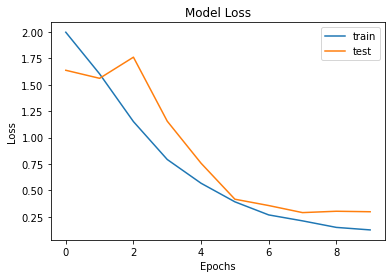

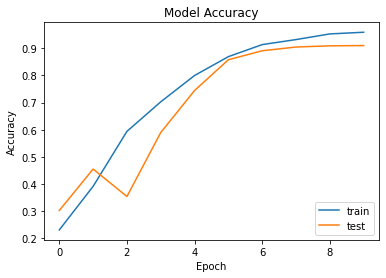

In [140]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'], loc = 'upper right')
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

# GPU Acceleration

In [31]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU'))) #check GPU Available
tf.test.gpu_device_name()


Num GPUs Available:  1


'/device:GPU:0'

In [24]:
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [32]:
# memory footprint support libraries/code
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 10.8 GB  | Proc size: 2.7 GB
GPU RAM Free: 14337MB | Used: 772MB | Util   5% | Total 15109MB


In [33]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.20GHz


In [34]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-10f67796-fee7-928e-5d30-81964ce027d0)


In [ ]:
!nvidia-smi